# IT1244 Project

Import Libraries

In [185]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold


In [125]:
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [229]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header = None, names=['sentiment', 'text'])

## Initial Exploratory Data Analysis

Tweet length statistics:
          char_length                                                      \
                count      mean        std  min   25%   50%    75%    max   
sentiment                                                                   
0             50000.0  73.55150  36.689293  6.0  43.0  69.0  103.0  186.0   
1             50000.0  73.93676  35.849812  7.0  44.0  69.0  103.0  166.0   

          word_count                                                  
               count      mean       std  min  25%   50%   75%   max  
sentiment                                                             
0            50000.0  13.44774  7.042649  1.0  8.0  12.0  19.0  35.0  
1            50000.0  12.79208  6.774854  1.0  7.0  12.0  18.0  35.0  


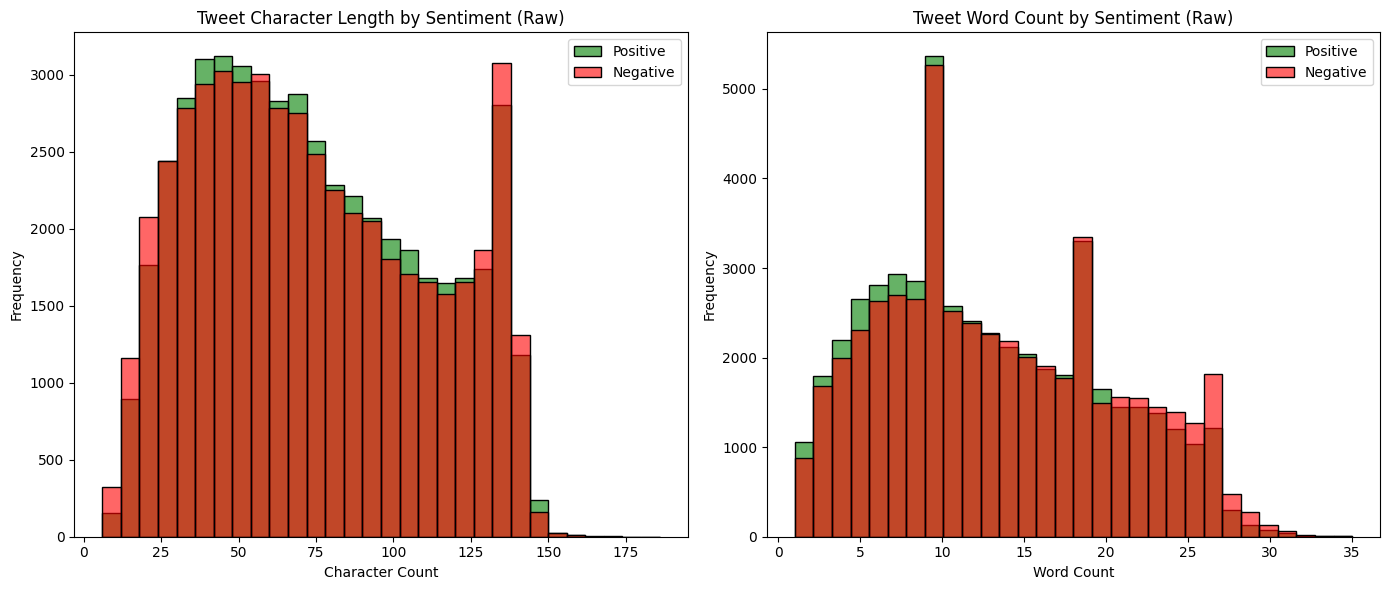

In [200]:
df = tweets.copy()

df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Calculate statistics by sentiment
length_stats = df.groupby('sentiment')[['char_length', 'word_count']].describe()

print("Tweet length statistics:")
print(length_stats)

# Plot length distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='char_length', hue='sentiment', 
            bins=30, alpha=0.6, palette=['red', 'green'])
plt.title('Tweet Character Length by Sentiment (Raw)')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='sentiment', 
            bins=30, alpha=0.6, palette=['red', 'green'])
plt.title('Tweet Word Count by Sentiment (Raw)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

plt.tight_layout()


Character count between negative and positive are similar, but negative sentiment tweets have a higher Word count on average 

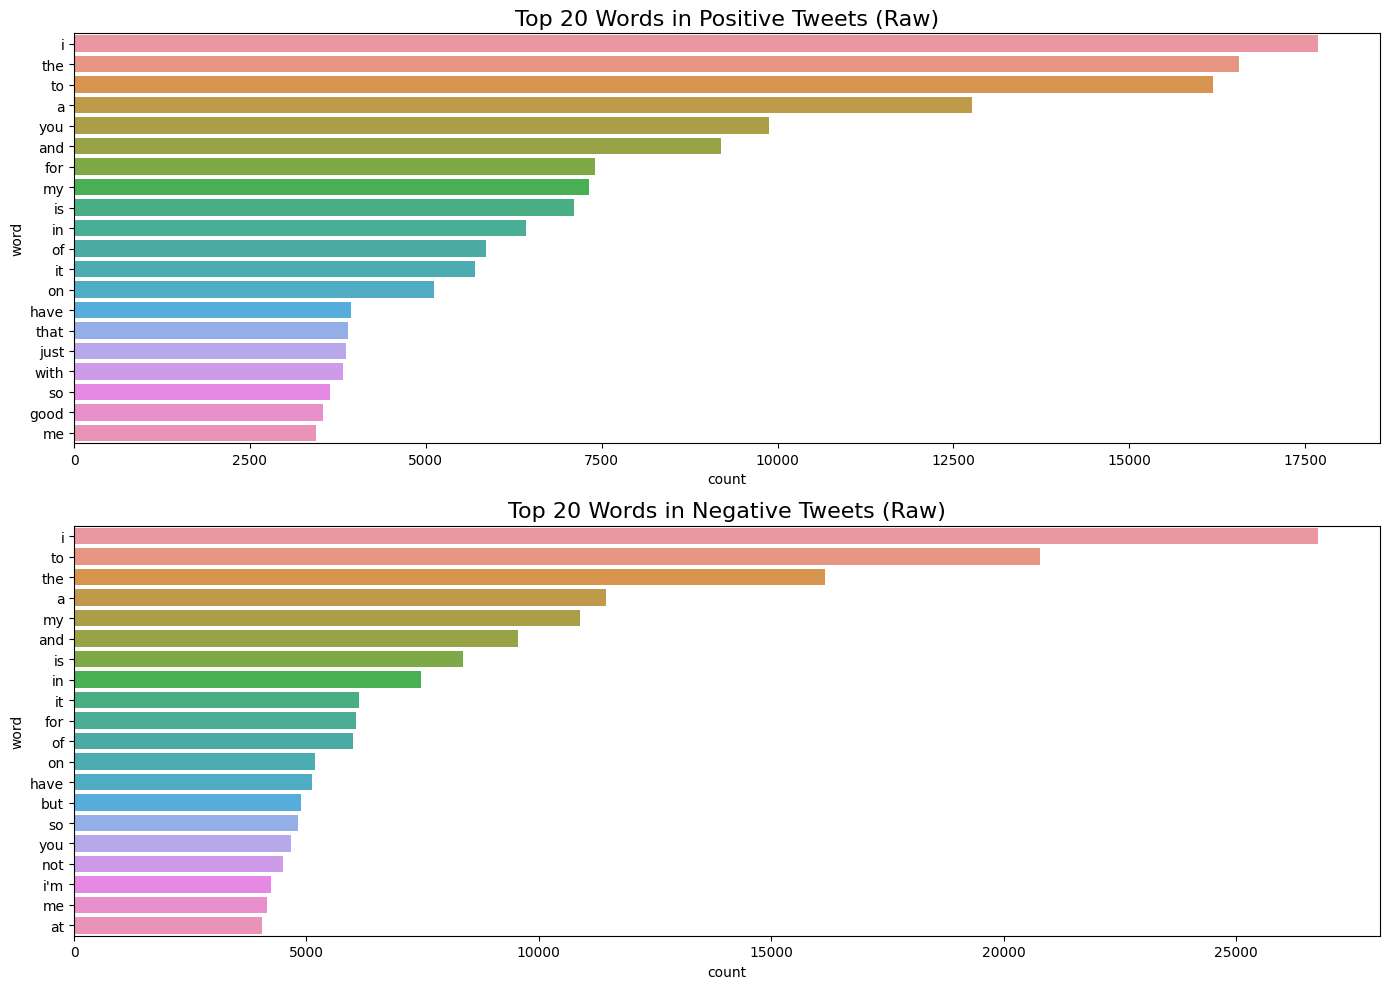

In [201]:
top_n = 20

# Function to extract words from a tweet
def get_words(text):
    return str(text).lower().split()

# Get all words by sentiment
positive_words = [word for tweet in tweets[tweets['sentiment'] == 1]['text'] for word in get_words(tweet)]
negative_words = [word for tweet in tweets[tweets['sentiment'] == 0]['text'] for word in get_words(tweet)]

# Count word frequencies
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)
top_positive = positive_word_counts.most_common(top_n)
top_negative = negative_word_counts.most_common(top_n)
pos_df = pd.DataFrame(top_positive, columns=['word', 'count'])
neg_df = pd.DataFrame(top_negative, columns=['word', 'count'])

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='count', y='word', data=pos_df)
plt.title(f'Top {top_n} Words in Positive Tweets (Raw)', fontsize=16)

plt.subplot(2, 1, 2)
sns.barplot(x='count', y='word', data=neg_df)
plt.title(f'Top {top_n} Words in Negative Tweets (Raw)', fontsize=16)

plt.tight_layout()


Top 3 words for both negative and positive tweets are the same. Thus they should not be used to predict the sentiment of a tweet. Stop Words should be removed

--- WORD CLOUD ANALYSIS ---


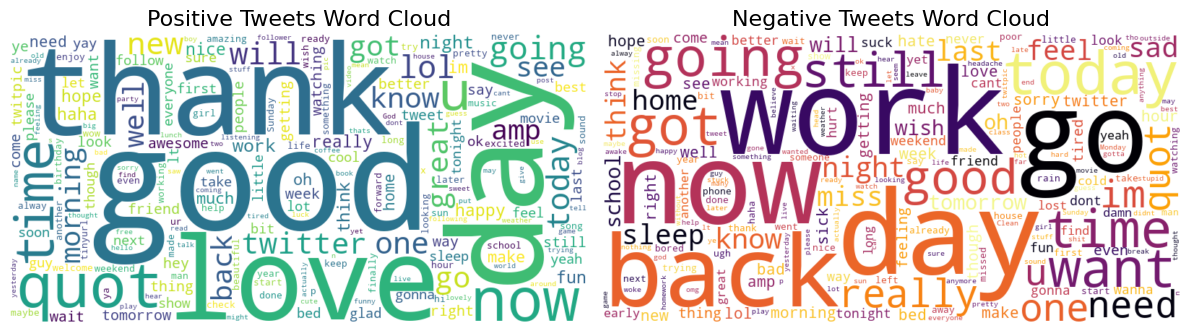

In [202]:
print("--- WORD CLOUD ANALYSIS ---")

# Combine all positive and negative tweets
positive_text = ' '.join(tweets[tweets['sentiment'] == 1]['text'].astype(str))
negative_text = ' '.join(tweets[tweets['sentiment'] == 0]['text'].astype(str))

# Create and plot positive word cloud
plt.figure(figsize=(12, 6))

wc_positive = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    collocations=False,
    colormap='viridis'
).generate(positive_text)

plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets Word Cloud', fontsize=16)

# Create and plot negative word cloud
wc_negative = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    collocations=False,
    colormap='inferno'
).generate(negative_text)

plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Tweets Word Cloud', fontsize=16)

plt.tight_layout()


Word Cloud automatically removes Stop Words, but other words such as "quot", "amp" and also slang stop words such as "u" and "im" should also be removed.

In [203]:
def classify_emoticons(text):

    # To account for reading :/ in http://
    text = re.sub(r'http\S+', '', text)

    positive_emoticons = [
        r'[:;=]-?[)D\]}]',  # Basic smiles :) ;) =) :D etc
        r'[:;=]-?[pP]',      # Tongue out :P
        r'<3',               # Heart
        r'\([:,;=]\)',       # (: (;
        r':-?[*]',           # Kisses
        r'[oO][._][oO]',     # o.O
        r'[;:]-?b',          # :b
        r'[:;=]-?[3]',       # Hearts/kisses
        r'[xX]D',            # Big grin XD
        r':-?[oO]',          # Surprised but often positive :O
        r'[;:]-?[\']',       # Happy tear/wink :\
        r'\^[._]\^',         # Happy eyes
        r'\^-?\^',           # Happy face
    ]
    
    negative_emoticons = [
        r'[:;=]-?[(\[{]',    # Frowns :( ;( =( etc
        r':[\/\\]',          # Skeptical/unsure
        r'>[:]',             # Angry
        r'[:;=]-?[xX]',      # Eyes shut in pain
        r'[:|]-?\|',         # Straight face (neutral/negative)
        r'[o0][._][o0]',     # Shocked or worried
        r'D-?[:;=]',         # Very unhappy
        r'v[._]v',           # Downcast eyes
        r'[x]-?[x]',         # Dead/unconscious
        r'[T]-?[T]',         # Crying T_T
        r'[;:][\']-?\(',     # Crying 
        r'[;:][_]-?\(',      # Crying hard
        r'-[._]-',           # Expressionless/sad
    ]
    
    pos_count = 0
    neg_count = 0
    
    # Check and count all instances of positive emoticons
    for pattern in positive_emoticons:
        matches = re.findall(pattern, text)
        pos_count += len(matches)
    
    # Check and count all instances of negative emoticons
    for pattern in negative_emoticons:
        matches = re.findall(pattern, text)
        neg_count += len(matches)
    
    return pos_count, neg_count

Percentage of tweets containing each Twitter element:
                    positive  negative
mentions              55.140    34.772
hashtags               2.038     1.584
urls                   6.020     2.714
exclamations          33.950    24.188
questions             11.100     9.684
positive_emoticons     3.258     2.162
negative_emoticons     1.588     1.598
ellipsis              12.844    16.254
all_caps              14.342    12.968


Average counts of Twitter elements per tweet:
                    positive  negative
mentions             0.58256   0.36148
hashtags             0.02354   0.01852
urls                 0.06176   0.02774
exclamations         0.61920   0.45334
questions            0.15402   0.14426
positive_emoticons   0.03470   0.02292
negative_emoticons   0.01876   0.01908
ellipsis             0.15414   0.19678
all_caps             0.24248   0.24160


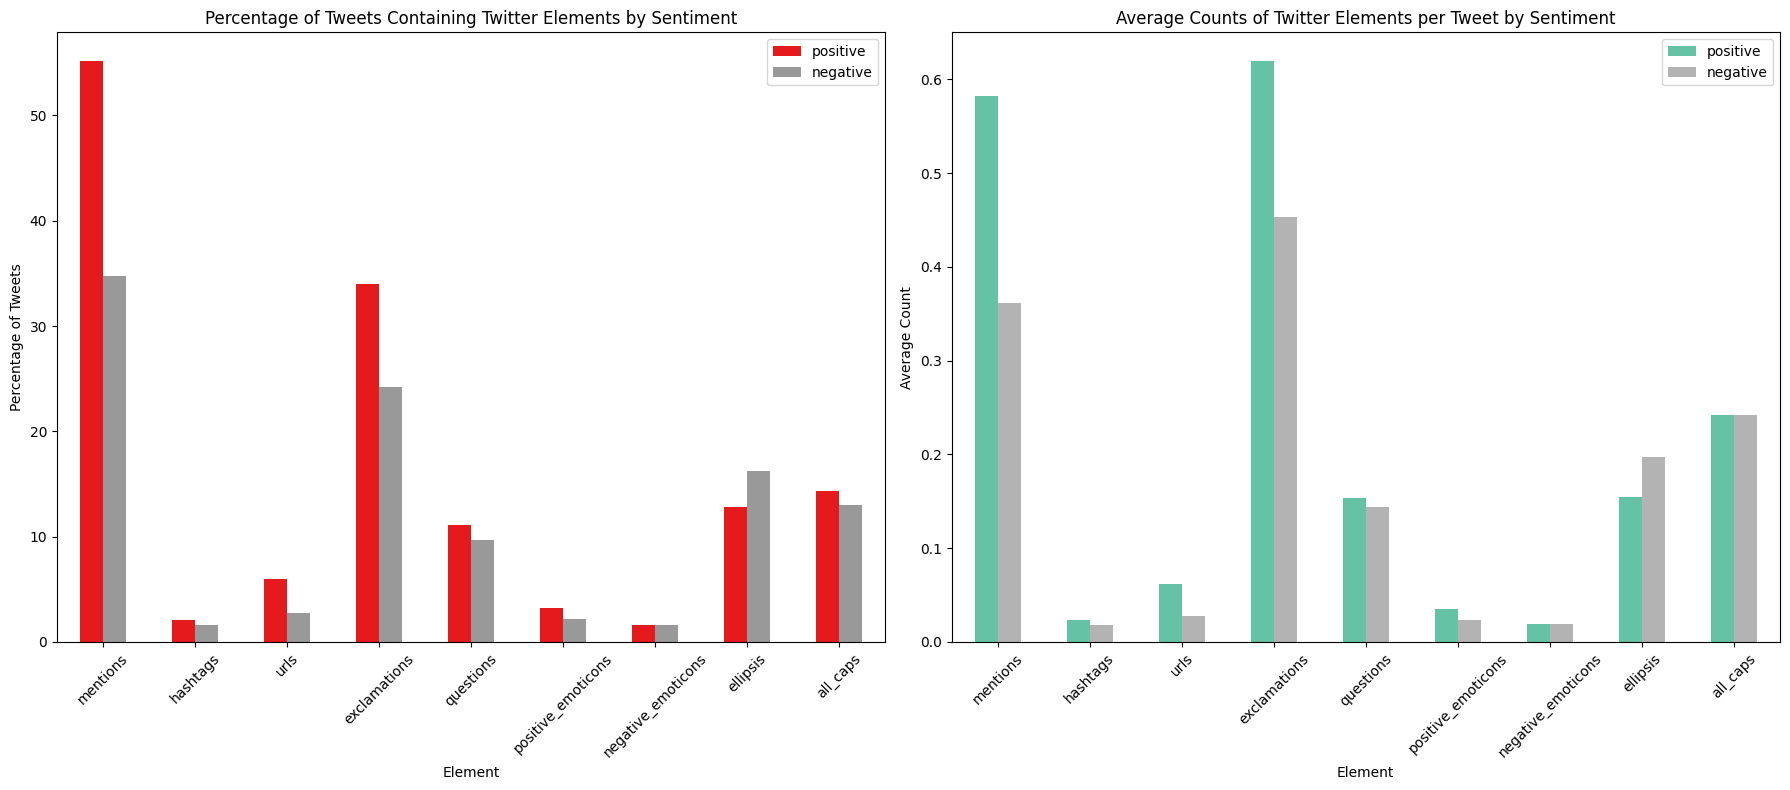

In [204]:
df = tweets.copy()


# Count Twitter-specific features
df['mentions'] = df['text'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
df['hashtags'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
df['urls'] = df['text'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+|twitpic', str(x))))
df['exclamations'] = df['text'].apply(lambda x: len(re.findall(r'!', str(x))))
df['questions'] = df['text'].apply(lambda x: len(re.findall(r'\?', str(x))))
df['positive_emoticons'] = df['text'].apply(lambda x: classify_emoticons(x)[0])
df['negative_emoticons'] = df['text'].apply(lambda x: classify_emoticons(x)[1])
df['ellipsis'] = df['text'].apply(lambda x: len(re.findall(r'\.{3,}', str(x))))
df['all_caps'] = df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', str(x))))

# Calculate percentage of tweets with each Twitter element
twitter_elements = ['mentions', 'hashtags', 'urls', 'exclamations', 'questions', 
                    'positive_emoticons', 'negative_emoticons', 'ellipsis', 'all_caps']

element_percentages = {}
for element in twitter_elements:
    pos_pct = (df[df['sentiment'] == 1][element] > 0).mean() * 100
    neg_pct = (df[df['sentiment'] == 0][element] > 0).mean() * 100
    element_percentages[element] = {'positive': pos_pct, 'negative': neg_pct}

element_df = pd.DataFrame(element_percentages).T

print("Percentage of tweets containing each Twitter element:")
print(element_df)
element_averages = {}
for element in twitter_elements:
    pos_avg = df[df['sentiment'] == 1][element].mean()
    neg_avg = df[df['sentiment'] == 0][element].mean()
    element_averages[element] = {'positive': pos_avg, 'negative': neg_avg}

average_df = pd.DataFrame(element_averages).T

print("\n")
print("Average counts of Twitter elements per tweet:")
print(average_df)

# Plotting graph side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot percentage of tweets containing each Twitter element
element_df.plot(
    kind='bar',
    colormap='Set1',
    ax=axes[0],
    legend=True
)
axes[0].set_title('Percentage of Tweets Containing Twitter Elements by Sentiment')
axes[0].set_xlabel('Element')
axes[0].set_ylabel('Percentage of Tweets')
axes[0].tick_params(axis='x', rotation=45)

# Plot average counts of Twitter elements per tweet
average_df.plot(
    kind='bar',
    colormap='Set2',
    ax=axes[1],
    legend=True
)
axes[1].set_title('Average Counts of Twitter Elements per Tweet by Sentiment')
axes[1].set_xlabel('Element')
axes[1].set_ylabel('Average Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




The count of 'mentions', 'hashtags', 'urls', 'exclamations', 'ellipsis' in each tweet could be used as a contributing factor to predict whether a tweet has positive or negative sentiments.

Surprisingly, negative emoticons are about as frequent in positive tweets as those in negative tweets. Emoticons might not be a good indicator as positive and negative emtoticons can also be used sarcastically. Though, it does seem that positive tweets generally have more emoticons than negative tweets.

## Data Cleaning/ Basic Feature Extraction

Extracting relevant features
Removing relevant StopWords, lowercasing, stemmings, amp, 

In [230]:
# Extracting relevant features

tweets['mentions'] = tweets['text'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
tweets['hashtags'] = tweets['text'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
tweets['urls'] = tweets['text'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+|twitpic', str(x))))
tweets['exclamations'] = tweets['text'].apply(lambda x: len(re.findall(r'!', str(x))))
tweets['emoticons'] = tweets['text'].apply(lambda x: classify_emoticons(x)[0]+classify_emoticons(x)[1])
tweets['ellipsis'] = tweets['text'].apply(lambda x: len(re.findall(r'\.{3,}', str(x))))

In [231]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'you', 'again', 'does', 'shan', "it'll", "wasn't", "wouldn't", 'here', 'won', 'no', 'y', 'and', 'had', 'it', 'too', 'don', 'that', 'until', 'they', 'isn', 'into', 'more', 'or', "they'll", 'after', "doesn't", 'these', 'few', 'above', 'then', 'by', 'during', "it'd", 'haven', 'being', 'your', 'against', "haven't", 'mightn', 'from', 'now', "they've", 'in', 'having', "he's", 'them', "i'm", "you've", 'he', "mustn't", 'aren', 'those', 'below', 'was', 'we', 'down', 'as', 'through', 'whom', 'have', "you'll", "she'll", 'before', 'be', "i've", 'where', 'yourselves', 'on', 'how', 'm', 'not', 'why', 'do', 'very', 'am', 'just', "aren't", "i'll", 'themselves', 'doesn', 'of', 's', 'should', 'who', 'both', 'their', "we'd", 'been', 'while', 'same', 'out', 'ours', 'is', 'wouldn', 'she', 'ain', 'an', 'between', 'shouldn', "they'd", "shan't", "he'd", 'hadn', 'are', "she's", 'other', 'has', "didn't", 'if', 'needn', "hadn't", 'any', 'mustn', 'me', 'll', "weren't", 'up', "you're", 'at', "hasn't", 'himself', 

In [232]:
# Remove irrelevant features

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_amp(text):
    return re.sub(r'&\w+;', '', text)

def at_filter(text):
    return re.sub(r"@\w+", "", text)

def lower_case(text):
    return text.lower()

def process_text(text):

    # Remove stopwords 
    stop_words = set(stopwords.words('english'))
    
    # Words to add to stopwords
    add_words = {
        "day", "u",
        "ur", "aint",
        "im", "quot"
    }

    # Words to preserve 
    preserve_words = {
        "isn't", "is",
        "wasn't", "was",
        "aren't", "are",
        "doesn't", "does",
        "couldn't", "could",
        "won't", "will",
        "shouldn't", "should",
        "didn't", "did",
        "haven't", "have",
        "no", "not"
    }
    

    filtered_stopwords = (stop_words - preserve_words).union(add_words)

    filtered_tokens = [token for token in text if token not in filtered_stopwords]

    
    return filtered_tokens

In [233]:
tweets.head()

,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,0,1,0,1,0
1,0,is upset that he can't update his Facebook by ...,0,0,0,1,0,1
2,0,@Kenichan I dived many times for the ball. Man...,1,0,0,0,0,0
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0
4,0,"@nationwideclass no, it's not behaving at all....",1,0,0,0,0,0


In [234]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tweets["text"] = tweets["text"].apply(lambda x: at_filter(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_amp(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_urls(x))
tweets["text"] = tweets["text"].apply(lambda x: lower_case(x))
tokenizer = TweetTokenizer()
tweets['processed_text'] = tweets['text'].apply(tokenizer.tokenize)
tweets['processed_text'] = tweets['processed_text'].apply(process_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [235]:
tweets.head()

,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,processed_text
0,0,"- awww, that's a bummer. you shoulda got da...",1,0,1,0,1,0,"[-, awww, ,, that's, bummer, ., shoulda, got, ..."
1,0,is upset that he can't update his facebook by ...,0,0,0,1,0,1,"[is, upset, can't, update, facebook, texting, ..."
2,0,i dived many times for the ball. managed to s...,1,0,0,0,0,0,"[dived, many, times, ball, ., managed, save, 5..."
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,"[whole, body, feels, itchy, like, fire]"
4,0,"no, it's not behaving at all. i'm mad. why am...",1,0,0,0,0,0,"[no, ,, not, behaving, ., mad, ., ?, can't, se..."


In [236]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [237]:
tweets['processed_text'] = tweets['processed_text'].apply(lemmatize_tokens)

In [ ]:
#tweets = tweets.dropna(subset=['processed_text'])

In [259]:
print(tweets.isnull().sum())  # Check for null values

Unnamed: 0          0
sentiment           0
text                0
mentions            0
hashtags            0
urls                0
exclamations        0
emoticons           0
ellipsis            0
processed_text    258
dtype: int64


In [251]:
tweets.shape

(100000, 10)

Save Cleaned File

In [240]:
tweets.to_csv("CleanedTweets.csv")

In [257]:
tweets = pd.read_csv('CleanedTweets.csv')

In [258]:
tweets.head()

,Unnamed: 0,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,processed_text
0,0,0,"- awww, that's a bummer. you shoulda got da...",1,0,1,0,1,0,"- awww , that's bummer . shoulda got david car..."
1,1,0,is upset that he can't update his facebook by ...,0,0,0,1,0,1,is upset can't update facebook texting ... mig...
2,2,0,i dived many times for the ball. managed to s...,1,0,0,0,0,0,dived many time ball . managed save 50 % rest ...
3,3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,whole body feel itchy like fire
4,4,0,"no, it's not behaving at all. i'm mad. why am...",1,0,0,0,0,0,"no , not behaving . mad . ? can't see ."


In [263]:
# Find the first row with a NaN value
first_null_row = tweets[tweets.isnull().any(axis=1)].head(1)

# Print the result
print(first_null_row['text'])

208     
Name: text, dtype: object


## Encodings

### Split Data Set

In [267]:
def load_and_split_data(file_path, test_size=0.2, random_state=42):

    df = pd.read_csv(file_path)
    
    X = df.drop('sentiment', axis=1)
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    X_train['processed_text'] = X_train['processed_text'].fillna("").astype(str)
    X_test['processed_text'] = X_test['processed_text'].fillna("").astype(str)
    return X_train, X_test, y_train, y_test

In [268]:
X_train, X_test, y_train, y_test = load_and_split_data("CleanedTweets.csv")

### Bag of Words Encoding

In [269]:
def encode_bow(X_train, X_test, ngram_range=(1, 1), max_features=5000):
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range
    )
    
    X_train_bow = vectorizer.fit_transform(X_train['processed_text'])
    X_test_bow = vectorizer.transform(X_test['processed_text'])
    
    return X_train_bow, X_test_bow, vectorizer

In [270]:
encode_bow(X_train, X_test)

(<80000x5000 sparse matrix of type '<class 'numpy.int64'>'
 	with 507232 stored elements in Compressed Sparse Row format>,
 <20000x5000 sparse matrix of type '<class 'numpy.int64'>'
 	with 126089 stored elements in Compressed Sparse Row format>,
 CountVectorizer(max_features=5000))

### TF-IDF Encoding

In [173]:
def encode_tfidf(X_train, X_test, ngram_range=(1, 1), max_features=5000):
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
    X_test_tfidf = vectorizer.transform(X_test['processed_text'])

    return X_train_tfidf, X_test_tfidf, vectorizer

In [174]:
encode_tfidf(X_train, X_test)

(<79793x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 506931 stored elements in Compressed Sparse Row format>,
 <19949x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 126318 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(max_features=5000))

### VADERS Encoding

In [166]:
nltk.download('vader_lexicon', quiet=True)

True

In [180]:
def encode_vader(X_train, X_test):
    vader = SentimentIntensityAnalyzer()
    
    def extract_vader_scores(texts):
        compound_scores = []
        positive_scores = []
        negative_scores = []
        neutral_scores = []
        
        for text in texts:
            scores = vader.polarity_scores(str(text))
            compound_scores.append(scores['compound'])
            positive_scores.append(scores['pos'])
            negative_scores.append(scores['neg'])
            neutral_scores.append(scores['neu'])
        
        return pd.DataFrame({
            'vader_compound': compound_scores,
            'vader_positive': positive_scores,
            'vader_negative': negative_scores,
            'vader_neutral': neutral_scores
        })
    
    X_train_vader = extract_vader_scores(X_train['text'])
    X_test_vader = extract_vader_scores(X_test['text'])
    
    return X_train_vader, X_test_vader

In [ ]:
encode_vader(X_train, X_test)

Extracting VADER sentiment scores...


(       vader_compound  vader_positive  vader_negative  vader_neutral
 0              0.0000           0.000           0.000          1.000
 1              0.0000           0.000           0.000          1.000
 2              0.6369           0.512           0.000          0.488
 3              0.5972           0.493           0.000          0.507
 4              0.0000           0.000           0.000          1.000
 ...               ...             ...             ...            ...
 79788          0.0516           0.267           0.233          0.500
 79789          0.6124           0.625           0.000          0.375
 79790          0.3400           0.444           0.000          0.556
 79791          0.3612           0.161           0.000          0.839
 79792          0.4019           0.252           0.000          0.748
 
 [79793 rows x 4 columns],
        vader_compound  vader_positive  vader_negative  vader_neutral
 0              0.0000           0.000           0.000       

### Combine Cleaned Dataset with each encoding

In [ ]:
def create_fold_datasets(X_fold_train, X_fold_val):
    # Get original features
    feature_cols = ['mentions', 'hashtags', 'urls', 'exclamations', 'emoticons', 'ellipsis']
    X_fold_train_features = X_fold_train[feature_cols].copy()
    X_fold_val_features = X_fold_val[feature_cols].copy()
    
    # Create datasets dictionary
    fold_datasets = {}
    
    # 1. Original features only
    fold_datasets['original'] = (X_fold_train_features, X_fold_val_features)
    
    # 2. BOW features only
    bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
    X_fold_train_bow = bow_vectorizer.fit_transform(X_fold_train['processed_text'])
    X_fold_val_bow = bow_vectorizer.transform(X_fold_val['processed_text'])
    
    # Convert to DataFrame
    bow_train_df = pd.DataFrame(
        X_fold_train_bow.toarray(),
        columns=[f'bow_{i}' for i in range(X_fold_train_bow.shape[1])]
    )
    bow_val_df = pd.DataFrame(
        X_fold_val_bow.toarray(),
        columns=[f'bow_{i}' for i in range(X_fold_train_bow.shape[1])]
    )
    
    fold_datasets['bow_only'] = (bow_train_df, bow_val_df)
    
    # 3. TF-IDF features only
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_fold_train_tfidf = tfidf_vectorizer.fit_transform(X_fold_train['processed_text'])
    X_fold_val_tfidf = tfidf_vectorizer.transform(X_fold_val['processed_text'])
    
    # Convert to DataFrame
    tfidf_train_df = pd.DataFrame(
        X_fold_train_tfidf.toarray(),
        columns=[f'tfidf_{i}' for i in range(X_fold_train_tfidf.shape[1])]
    )
    tfidf_val_df = pd.DataFrame(
        X_fold_val_tfidf.toarray(),
        columns=[f'tfidf_{i}' for i in range(X_fold_train_tfidf.shape[1])]
    )
    
    fold_datasets['tfidf_only'] = (tfidf_train_df, tfidf_val_df)
    
    # 4. VADER features only
    vader = SentimentIntensityAnalyzer()
    
    def get_vader_scores(texts):
        scores_df = pd.DataFrame()
        scores_df['vader_compound'] = [vader.polarity_scores(str(t))['compound'] for t in texts]
        scores_df['vader_pos'] = [vader.polarity_scores(str(t))['pos'] for t in texts]
        scores_df['vader_neg'] = [vader.polarity_scores(str(t))['neg'] for t in texts]
        scores_df['vader_neu'] = [vader.polarity_scores(str(t))['neu'] for t in texts]
        return scores_df
    
    X_fold_train_vader = get_vader_scores(X_fold_train['text'])
    X_fold_val_vader = get_vader_scores(X_fold_val['text'])
    
    fold_datasets['vader_only'] = (X_fold_train_vader, X_fold_val_vader)
    
    # 5. Combined datasets
    # BOW + original
    X_fold_train_bow_combined = pd.concat([X_fold_train_features.reset_index(drop=True), 
                                         bow_train_df.reset_index(drop=True)], axis=1)
    X_fold_val_bow_combined = pd.concat([X_fold_val_features.reset_index(drop=True), 
                                       bow_val_df.reset_index(drop=True)], axis=1)
    
    fold_datasets['bow_combined'] = (X_fold_train_bow_combined, X_fold_val_bow_combined)
    
    # TF-IDF + original
    X_fold_train_tfidf_combined = pd.concat([X_fold_train_features.reset_index(drop=True), 
                                           tfidf_train_df.reset_index(drop=True)], axis=1)
    X_fold_val_tfidf_combined = pd.concat([X_fold_val_features.reset_index(drop=True), 
                                         tfidf_val_df.reset_index(drop=True)], axis=1)
    
    fold_datasets['tfidf_combined'] = (X_fold_train_tfidf_combined, X_fold_val_tfidf_combined)
    
    # VADER + original
    X_fold_train_vader_combined = pd.concat([X_fold_train_features.reset_index(drop=True), 
                                           X_fold_train_vader.reset_index(drop=True)], axis=1)
    X_fold_val_vader_combined = pd.concat([X_fold_val_features.reset_index(drop=True), 
                                         X_fold_val_vader.reset_index(drop=True)], axis=1)
    
    fold_datasets['vader_combined'] = (X_fold_train_vader_combined, X_fold_val_vader_combined)
    
    # Return all datasets for this fold
    return fold_datasets

In [ ]:
def train_random_forest_with_kfold(X, y, n_folds=5):
    # Dictionary to store all results
    all_results = {}
    
    # Create KFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # List of datasets to evaluate
    dataset_names = [
        'original',          # Just original features
        'bow_only',          # Just BOW features
        'tfidf_only',        # Just TF-IDF features
        'vader_only',        # Just VADER features
        'bow_combined',      # BOW + original features
        'tfidf_combined',    # TF-IDF + original features
        'vader_combined'     # VADER + original features
    ]

    for name in dataset_names:
        all_results[name] = {
            'dataset': name,
            'cv_scores': [],
            'all_predictions': np.array([]),
            'all_true': np.array([])
        }
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nProcessing fold {fold+1}/{n_folds}...")
        
        # Split the data
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Generate DataSet for each fold to prevent leakage between train and test
        fold_datasets = create_fold_datasets(X_fold_train, X_fold_val)
        
        # Process each dataset type
        for dataset_name in dataset_names:
            print(f"  Training on {dataset_name}...")

            X_fold_train_data, X_fold_val_data = fold_datasets[dataset_name]
            
            # Train Random Forest on this fold and dataset
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            
            rf.fit(X_fold_train_data, y_fold_train)

            
            # Make predictions on validation fold
            fold_preds = rf.predict(X_fold_val_data)
            fold_score = accuracy_score(y_fold_val, fold_preds)
            
            # Store results for this dataset type
            all_results[dataset_name]['cv_scores'].append(fold_score)
            all_results[dataset_name]['all_predictions'] = np.append(
                all_results[dataset_name]['all_predictions'], fold_preds
            )
            all_results[dataset_name]['all_true'] = np.append(
                all_results[dataset_name]['all_true'], y_fold_val
            )
            
            # Feature importance (if available and first fold)
            if hasattr(rf, 'feature_importances_') and fold == 0:
                importances = rf.feature_importances_
                indices = np.argsort(importances)[::-1]
                features = X_fold_train_data.columns
                
                # Store top features
                top_features = []
                for i in range(min(10, len(features))):
                    feature_idx = indices[i]
                    top_features.append((features[feature_idx], importances[feature_idx]))
                
                all_results[dataset_name]['top_features'] = top_features
            

    
    # Calculate final metrics for each dataset type
    for name in dataset_names:
        # Calculate mean
        all_results[name]['mean_cv_accuracy'] = np.mean(all_results[name]['cv_scores'])
        all_results[name]['std_cv_accuracy'] = np.std(all_results[name]['cv_scores'])
        
        # Calculate confusion matrix
        all_results[name]['confusion_matrix'] = confusion_matrix(
            all_results[name]['all_true'], all_results[name]['all_predictions']
        )
        
        # Print results
        print(f"\n--- Results for {name} ---")
        print(f"accuracies: {all_results[name]['cv_scores']}")
        print(f"Mean 5-fold accuracy: {all_results[name]['mean_cv_accuracy']:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_results[name]['all_true'], all_results[name]['all_predictions']))
        
        # Print top features
        if 'top_features' in all_results[name]:
            print("\nTop 10 features from first fold:")
            for i, (feature, importance) in enumerate(all_results[name]['top_features'], 1):
                print(f"{i}. {feature}: {importance:.4f}")
    
    return all_results

In [279]:
# Load data
print("Loading data...")
df = pd.read_csv('CleanedTweets.csv')

# Handle NaN values in processed_text
df['processed_text'] = df['processed_text'].fillna('')
print(f"Loaded {len(df)} tweets")

# Prepare features and target
X = df.drop('sentiment', axis=1)
y = df['sentiment']

# Train with cross-validation
n_folds = 5
results = train_random_forest_with_kfold(X, y, n_folds)


Loading data...
Loaded 100000 tweets

Processing fold 1/5...
  Training on original...
  Training on bow_only...
  Training on tfidf_only...
  Training on vader_only...
  Training on bow_combined...
  Training on tfidf_combined...
  Training on vader_combined...

Processing fold 2/5...
  Training on original...
  Training on bow_only...
  Training on tfidf_only...
  Training on vader_only...
  Training on bow_combined...
  Training on tfidf_combined...
  Training on vader_combined...

Processing fold 3/5...
  Training on original...
  Training on bow_only...
  Training on tfidf_only...
  Training on vader_only...
  Training on bow_combined...
  Training on tfidf_combined...
  Training on vader_combined...

Processing fold 4/5...
  Training on original...
  Training on bow_only...
  Training on tfidf_only...
  Training on vader_only...
  Training on bow_combined...
  Training on tfidf_combined...
  Training on vader_combined...

Processing fold 5/5...
  Training on original...
  Trainin

In [280]:
# Print summary of all results
print("\n=== SUMMARY OF RESULTS ===")
for dataset_name in sorted(results.keys(), key=lambda k: results[k]['mean_cv_accuracy'], reverse=True):
    result = results[dataset_name]
    print(f"{dataset_name}: CV Accuracy = {result['mean_cv_accuracy']:.4f} ± {result['std_cv_accuracy']:.4f}, ")

# Identify best dataset
best_dataset = max(results.keys(), key=lambda k: results[k]['mean_cv_accuracy'])
print(f"\nBest dataset: {best_dataset} with CV accuracy {results[best_dataset]['mean_cv_accuracy']:.4f} ± " +
        f"{results[best_dataset]['std_cv_accuracy']:.4f}")


=== SUMMARY OF RESULTS ===
tfidf_combined: CV Accuracy = 0.7595 ± 0.0026, 
bow_combined: CV Accuracy = 0.7569 ± 0.0030, 
tfidf_only: CV Accuracy = 0.7566 ± 0.0032, 
bow_only: CV Accuracy = 0.7513 ± 0.0054, 
vader_combined: CV Accuracy = 0.6803 ± 0.0022, 
vader_only: CV Accuracy = 0.6521 ± 0.0020, 
original: CV Accuracy = 0.6102 ± 0.0024, 

Best dataset: tfidf_combined with CV accuracy 0.7595 ± 0.0026


## Models